In [727]:
#https://grabcad.com/library/ferrari-f1-75-2022-1 from here
#https://pimpmydrawing.com/cars

In [728]:
import matplotlib.pyplot as plt
from stl import mesh
import numpy as np
from scipy.spatial import Delaunay

import cv2
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.path import Path



In [729]:
def car(nx,ny,filename):
    # Load image and convert to grayscale
    image = cv2.imread(filename)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Detect white car
    _, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY) 
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        # Get car contour - use raw points without simplification
        pts = max(contours, key=cv2.contourArea)
        pts = pts.reshape(-1, 2).astype(np.float64) # convert to x and y

        scale = 1/25
        xoffset = int(nx/6)
        yoffset = ny - 5 

        x = pts[:, 0] * scale + xoffset # Scale down for better visualization
        y = -pts[:, 1] * scale + yoffset  # Invert y-axis

        # Make sure first and last points are connected
        if not np.allclose(x[0], x[-1]) or not np.allclose(y[0], y[-1]): # close the loop
            x = np.append(x, x[0]) 
            y = np.append(y, y[0])
            
        return x, y
    else:
        # Return empty arrays if no contours found
        return np.array([]), np.array([])


In [730]:
def grid(h=1):  # h in mm
    nx = int(100 / h) + 1    
    ny = int(20 / h) + 1    
    
    xvals = np.linspace(0, 100, nx)
    yvals = np.linspace(0, 20, ny)
    return nx, ny, xvals, yvals


In [731]:
def init(nx, ny, h):
    u = np.zeros((nx, ny), dtype=float)  # stream function
    w = np.zeros((nx, ny), dtype=float)  # vorticity field 
    v0 = 1.5
    omega = 0.025
    nu = 0.9
    iter = 0
    R = v0*h/nu
    return u, w, v0, omega, nu, iter, R


In [732]:
def edges(nx, ny, u, w, v0, h = 1):
    
    # init flow
    for i in range(nx):
        for j in range(ny): 
            w[i,j] = 0.0
            u[i,j] = j * v0  

    #top boundary
    for i in range(nx):
        u[i,ny-1] = u[i, ny-2] + v0 * h 
        w[i,ny-2] = 0.0

    #inlet
    for j in range(ny):
        u[1,j] = u[0,j]
        w[0,j] = 0.0

    #bot boundary 
    for i in range(nx):
        u[i, 0] = u[i, 1]  
        w[i, 0] = 0.0
        
    #outlet
    for j in range(1, ny-1):
        u[nx-1,j] = u[nx-2,j]
        w[nx-1,j] = w[nx-2,j]

    return u, w


In [733]:
def carBC(u, w, X, Y, car_x, car_y, h):
    """
    Use the car polygon for boundary conditions
    """
    # Create the car polygon path
    car_polygon = np.column_stack([car_x, car_y])
    car_path = Path(car_polygon)
    
    # Create mask for points inside car
    points = np.column_stack([X.ravel(), Y.ravel()])
    inside_car = car_path.contains_points(points).reshape(X.shape)
    
    # Set stream function to zero inside car
    u[inside_car] = 0.0
    
    # Apply vorticity boundary conditions
    for i in range(1, u.shape[0]-1):
        for j in range(1, u.shape[1]-1):
            if inside_car[i,j]:
                # Check neighbors to find the fluid side
                if not inside_car[i+1,j]:  # Right neighbor is in fluid
                    w[i,j] = -2.0 * u[i+1,j] / (h*h)
                elif not inside_car[i-1,j]:  # Left neighbor is in fluid
                    w[i,j] = -2.0 * u[i-1,j] / (h*h)
                elif not inside_car[i,j+1]:  # Top neighbor is in fluid
                    w[i,j] = -2.0 * u[i,j+1] / (h*h)
                elif not inside_car[i,j-1]:  # Bottom neighbor is in fluid
                    w[i,j] = -2.0 * u[i,j-1] / (h*h)
                else:
                    w[i,j] = 0.0  # Completely surrounded by car
                    
    return u, w


In [734]:
def relax(nx, ny, u, w, R, omega, h, X, Y, car_x, car_y, v0):
    # Apply car boundary conditions first
    u, w = carBC(u, w, X, Y, car_x, car_y, h)

    # Create car mask 
    car_polygon = np.column_stack([car_x, car_y])
    car_path = Path(car_polygon)
    points = np.column_stack([X.ravel(), Y.ravel()])
    outside_car = ~car_path.contains_points(points).reshape(X.shape)
    
    # Relax stream function (only for points outside car)
    for i in range(1, nx-1): 
        for j in range(1, ny-1):
            if outside_car[i,j]:  # only points outside car
                r1 = omega * ((u[i+1,j] + u[i-1,j] + u[i,j+1] + u[i,j-1] + h*h*w[i,j]) * 0.25 - u[i,j])
                u[i,j] += r1

    # Relax vorticity (only for points outside car)
    for i in range(1, nx-1):
        for j in range(1, ny-1):
            if outside_car[i,j]:  # only points outside car
                a1 = w[i+1,j] + w[i-1,j] + w[i,j+1] + w[i, j-1]
                a2 = (u[i, j+1] - u[i, j-1]) * (w[i+1,j] - w[i-1,j])
                a3 = (u[i+1, j] - u[i-1,j]) * (w[i,j+1] - w[i,j-1])
                r2 = omega * ((a1 - (R/4.0) * (a2 - a3)) / 4.0 - w[i,j])
                w[i,j] += r2
                
    return u, w


In [735]:
h = 1 # grid spacing

print("init")
nx, ny, xvals, yvals = grid(h)
car_x, car_y = car(nx, ny, "CAR.png")   
X, Y = np.meshgrid(xvals, yvals, indexing='ij') 
u, w, v0, omega, nu, iter, R = init (nx, ny, h)
print("BC")
u, w = edges (nx, ny, u, w, v0, h) # apply edge BCs first
u, w = carBC(u, w, X, Y, car_x, car_y, h) # apply object BCs


print("relax")
maxiter = 1000
tol = 1e-5
for iter in range(maxiter):
    u_old = u.copy()
    u, w = relax(nx, ny, u, w, R, omega, h, X, Y, car_x, car_y, v0)

    delta = np.max(np.abs(u - u_old))
    if iter % 100 == 0:
        print(f"Iteration: {iter}")

    if delta < tol:
        print(f"Converged after {iter} iterations.")
        break

print("plot")
# Create proper meshgrid for plotting
x = np.linspace(0, 100, nx)  # Use array indices for plotting
y = np.linspace(0, 20, ny)
xplot, yplot = np.meshgrid(x, y, indexing='ij')


init
BC
relax
Iteration: 0
Iteration: 100
Iteration: 200
Iteration: 300
Iteration: 400
Iteration: 500
Iteration: 600
Iteration: 700
Iteration: 800
Iteration: 900
plot


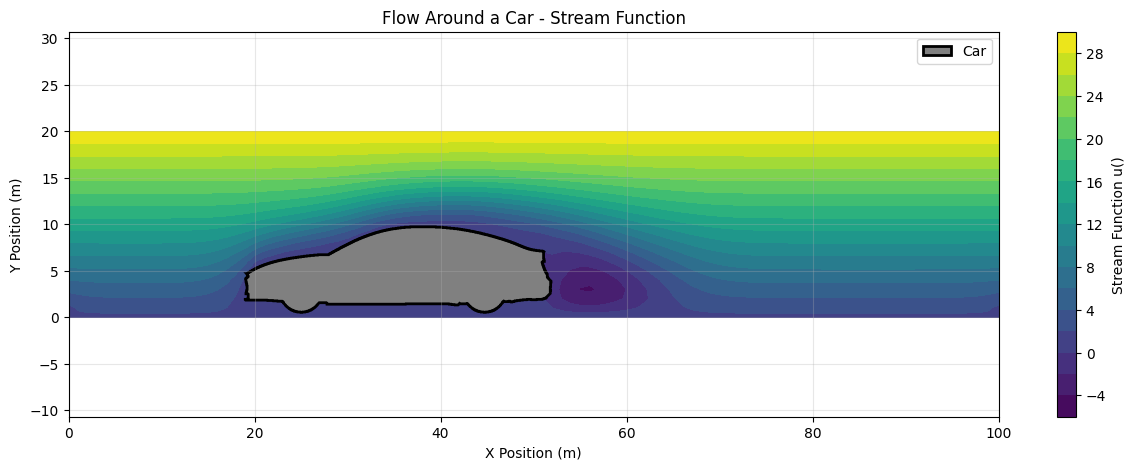

In [736]:
plt.figure(figsize=(15, 5))
contour = plt.contourf(xplot, yplot, u, levels=20, cmap='viridis')
plt.colorbar(contour, label='Stream Function u()')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.title('2D Stream Function Contours - Flow Around Car')
plt.axis('equal')

# Add car
plt.fill(car_x, car_y, color = 'gray',label='Car', edgecolor='black', linewidth=2)
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.title('Flow Around a Car - Stream Function')
plt.legend()
plt.axis('equal')
plt.grid(True, alpha=0.3)
plt.show()


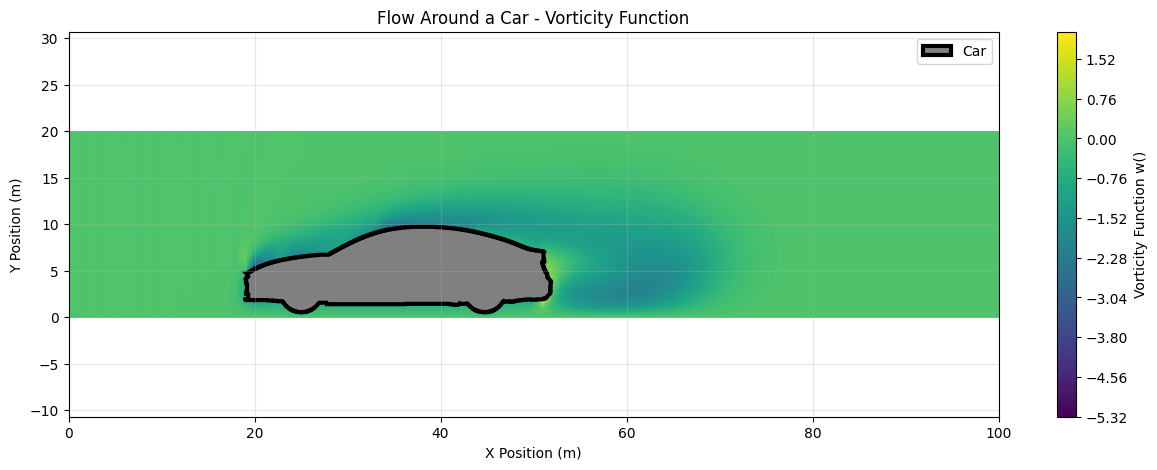

In [737]:
plt.figure(figsize=(15, 5))
contour = plt.contourf(xplot, yplot, w, levels=200, cmap='viridis')
plt.colorbar(contour, label='Vorticity Function w()')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.title('2D Vorticity Contours - Flow Around Car')
plt.axis('equal')

# Add car
plt.fill(car_x, car_y, color = 'gray',label='Car', edgecolor='black', linewidth=3)
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.title('Flow Around a Car - Vorticity Function')
plt.legend()
plt.axis('equal')
plt.grid(True, alpha=0.3)
plt.show()


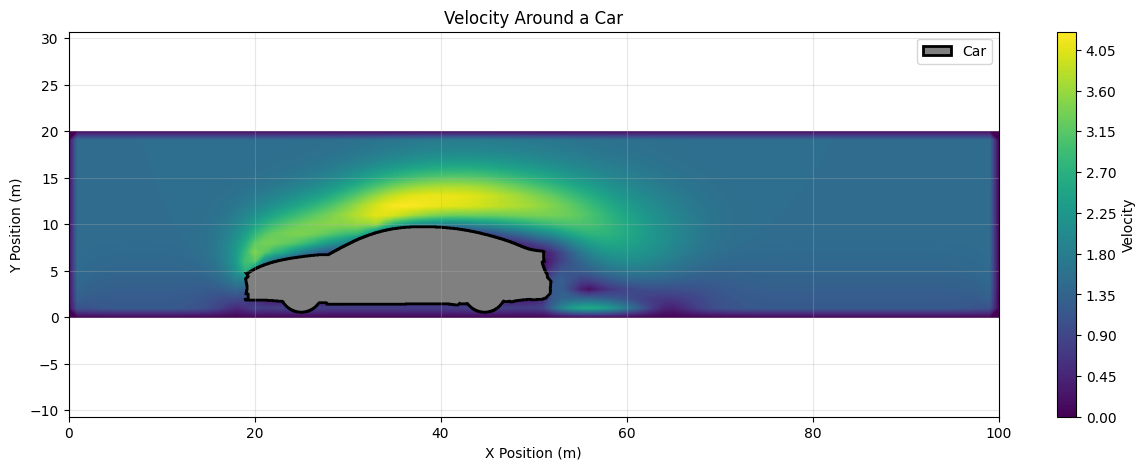

In [738]:
def calcVelo(u, h):
    nx, ny = u.shape
    vx = np.zeros((nx, ny))
    vy = np.zeros((nx, ny))
    
    for i in range(1, nx-1):
        for j in range(1, ny-1):
            vx[i,j] = (u[i,j+1] - u[i,j-1]) / (2 * h)   # eq 19.54 // central difference
            vy[i,j] = -(u[i+1,j] - u[i-1,j]) / (2 * h)  
            
    return vx, vy

vx, vy = calcVelo(u, h)
veloMag = np.sqrt(vx**2 + vy**2)

plt.figure(figsize=(15, 5))
contour = plt.contourf(xplot, yplot, veloMag, levels = 200, cmap='viridis')
plt.colorbar(contour, label='Velocity')
plt.fill(car_x, car_y, color='gray', label='Car', edgecolor='black', linewidth=2)
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.title('Velocity Around a Car')
plt.legend()
plt.axis('equal')
plt.grid(True, alpha=0.3)
plt.show()
